In [ ]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp 
import emcee 


plt.figure(figsize=(20,18))
assay_list = [
    (5e-7, 1e-3),
    (5e-8, 1e-3),
    (1e-7, 5e-3),
    (1e-7, 5e-4),
    (5e-7, 5e-4),
]
# assay_list = [
#     (5e-7, 1e-3),
#     (5e-8, 1e-3),
# ]

for assay_i in assay_list:
    y = []
    rr_model = te.loada('/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/antiporter_1_1_12D_cycle1/antiporter_1_1_12D_cycle1_antimony.txt')
    rr_model.exportToSBML('antiporter_1_1_12D_cycle1.xml')

    rr_model.resetToOrigin()
    print(rr_model['conc_OF'])
    rr_model.integrator.absolute_tolerance = 1e-15
    rr_model.integrator.relative_tolerance = 1e-9
    res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
    rr_model['conc_H_out'] = assay_i[0]
    rr_model['conc_S_out'] = assay_i[1]
    res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
    y.append(res['net_ion_influx'])
    rr_model['conc_H_out'] = 1e-7
    rr_model['conc_S_out'] = 1e-3
    res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
    y.append(res['net_ion_influx'])
    y_true = np.hstack(y)
    y_peak = np.max(y_true)
    noise_sigma = 1e-8
    y_obs = y_true + np.random.normal(0,noise_sigma, np.size(y_true))
    plt.plot(y_true[:])
    plt.plot(y_obs[:], 'o',label=f'{assay_i}')
plt.legend()

In [ ]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp 
import emcee 

rr_model = te.loada('/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/antiporter_1_1_12D_cycle2/antiporter_1_1_12D_cycle2_antimony.txt')

plt.figure(figsize=(20,18))

y = []

rr_model.resetToOrigin()
#print(rr_model['conc_OF'])
rr_model.integrator.absolute_tolerance = 1e-15
rr_model.integrator.relative_tolerance = 1e-12
res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
rr_model['conc_H_out'] = 5e-7
rr_model['conc_S_out'] = 1e-3
res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
y.append(res['net_ion_influx'])
rr_model['conc_H_out'] = 1e-7
rr_model['conc_S_out'] = 1e-3
res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
y.append(res['net_ion_influx'])
y_true = np.hstack(y)
y_peak = np.max(y_true)
noise_sigma = 1e-12
y_obs = y_true + np.random.normal(0,noise_sigma, np.size(y_true))
plt.plot(y_true[:])
plt.plot(y_obs[:], 'o',label=f'')
plt.legend()



#rr_model.exportToSBML('antiporter_1_1_12D_cycle2_sbml.xml')

In [ ]:
import numpy as np
log_evidence_m0 = np.array([3.005228127811760260e+03, 2.997971911335218465e+03])
log_evidence_m1 = np.array([2.801952594958798272e+03, 2.787253305507924779e+03])

bf = np.exp(np.mean(log_evidence_m0)-np.mean(log_evidence_m1))
print(bf)

# pymc4 test

Running on PyMC v5.2.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


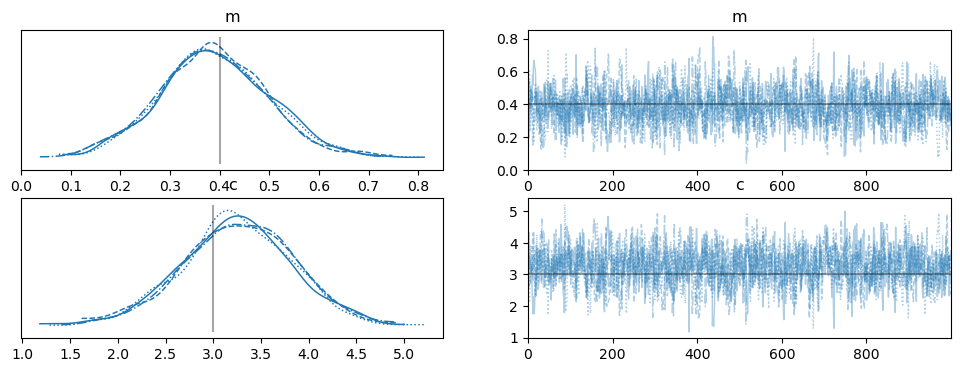

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

def my_model(theta, x):
    m, c = theta
    return m * x + c


def my_loglike(theta, x, data, sigma):
    model = my_model(theta, x)
    return -(0.5 / sigma**2) * np.sum((data - model) ** 2)


def normal_gradients(theta, x, data, sigma):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    theta: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    x, data, sigma:
        Observed variables as we have been using so far


    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.empty(2)
    aux_vect = data - my_model(theta, x)  # /(2*sigma**2)
    grads[0] = np.sum(aux_vect * x)
    grads[1] = np.sum(aux_vect)

    return grads


# define a pytensor Op for our likelihood function
class LogLikeWithGrad(pt.Op):

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        return [g[0] * self.logpgrad(theta)]


class LogLikeGrad(pt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """

    itypes = [pt.dvector]
    otypes = [pt.dvector]

    def __init__(self, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        (theta,) = inputs

        # calculate gradients
        grads = normal_gradients(theta, self.x, self.data, self.sigma)

        outputs[0][0] = grads

# set up our data
N = 10  # number of data points
sigma = 1.0  # standard deviation of noise
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4  # true gradient
ctrue = 3.0  # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC to sampler from log-likelihood
with pm.Model() as opmodel:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([m, c])

    # use a Potential
    pm.Potential("likelihood", logl(theta))

    idata_grad = pm.sample()

# plot the traces
_ = az.plot_trace(idata_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)])

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
log10_k1_f   9.258  0.507   8.772    9.963      0.335    0.275       3.0   
log10_k1_r   2.209  1.159   1.063    3.568      0.782    0.649       3.0   
log10_k2_f   0.020  0.294  -0.284    0.613      0.132    0.115      12.0   
log10_k2_r   2.128  0.925   1.288    3.515      0.619    0.512       2.0   
log10_k3_f   6.203  0.226   5.833    6.730      0.102    0.077       5.0   
log10_k3_r   1.755  0.300   1.536    2.288      0.181    0.145       3.0   
log10_k4_f   2.893  0.426   2.119    3.268      0.263    0.219       3.0   
log10_k4_r   8.910  1.121   7.405   10.009      0.753    0.627       3.0   
log10_k5_f   1.259  0.455   0.544    1.682      0.300    0.252       3.0   
log10_k5_r   1.157  0.852   0.341    2.355      0.573    0.475       3.0   
log10_k6_f   1.915  0.645   1.030    2.539      0.427    0.358       3.0   
log10_sigma -7.006  0.702  -7.707   -6.303      0.476    0.396       2.0   

           

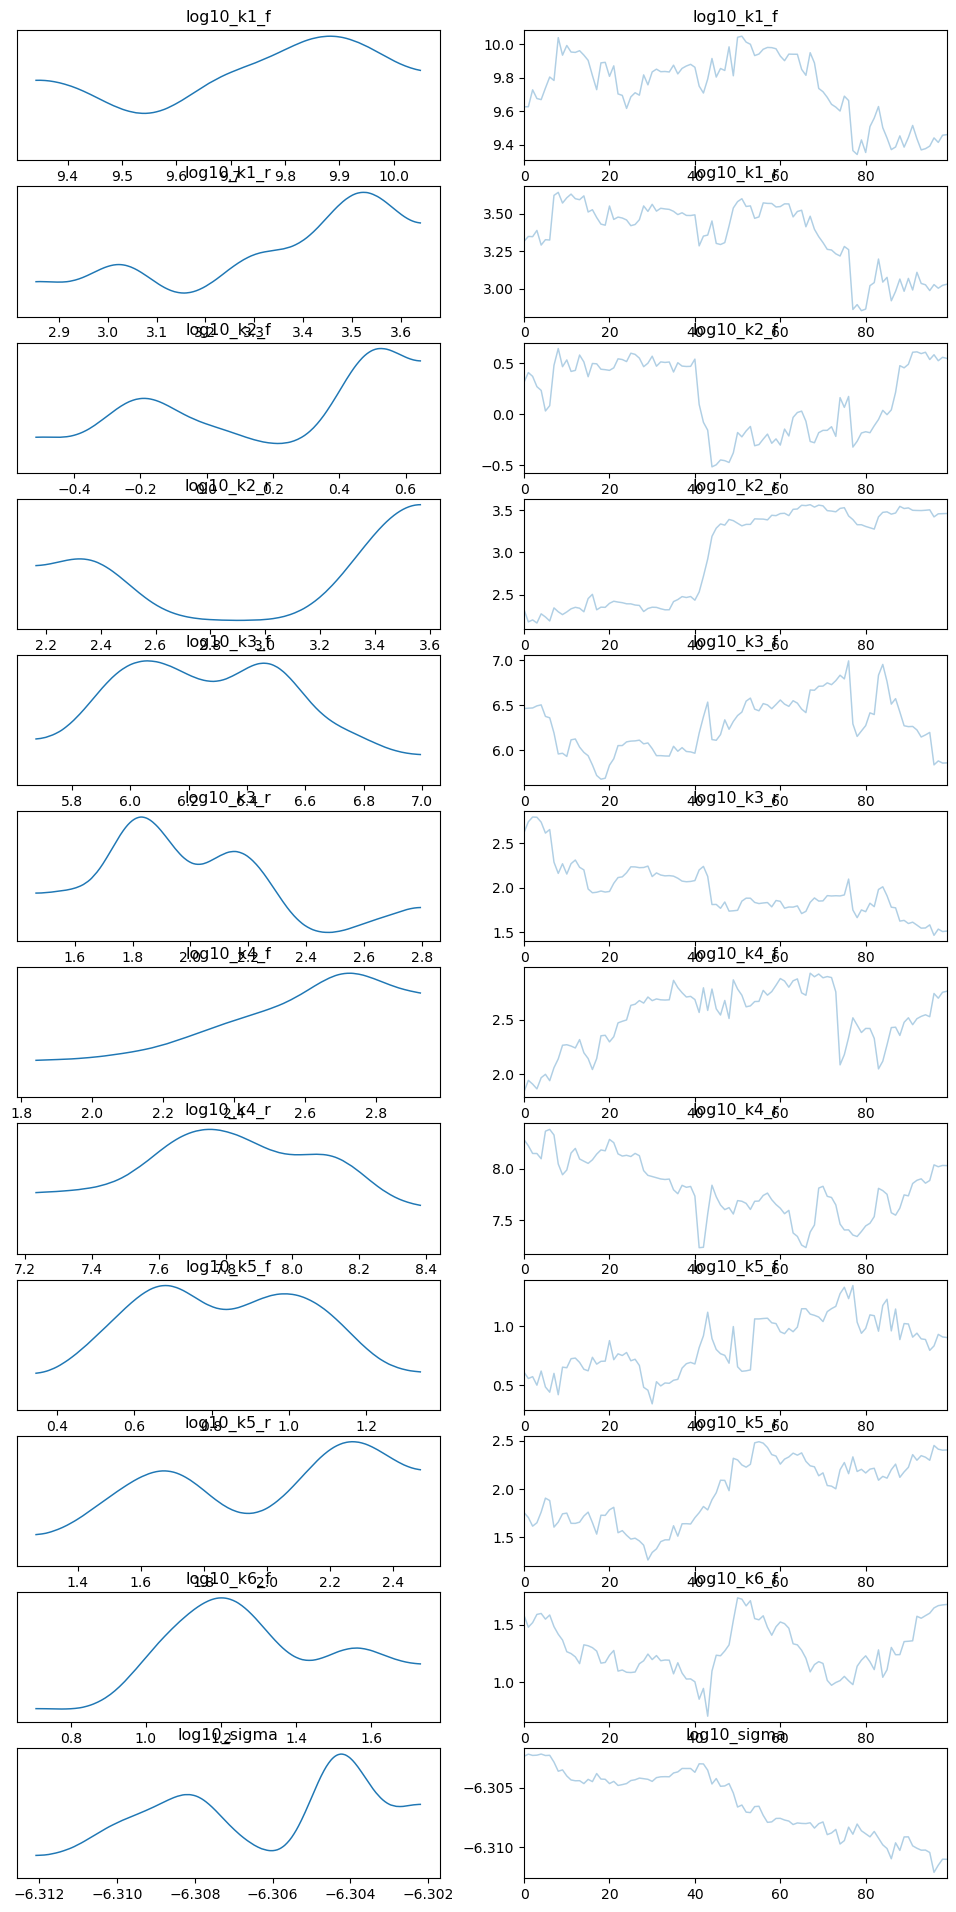

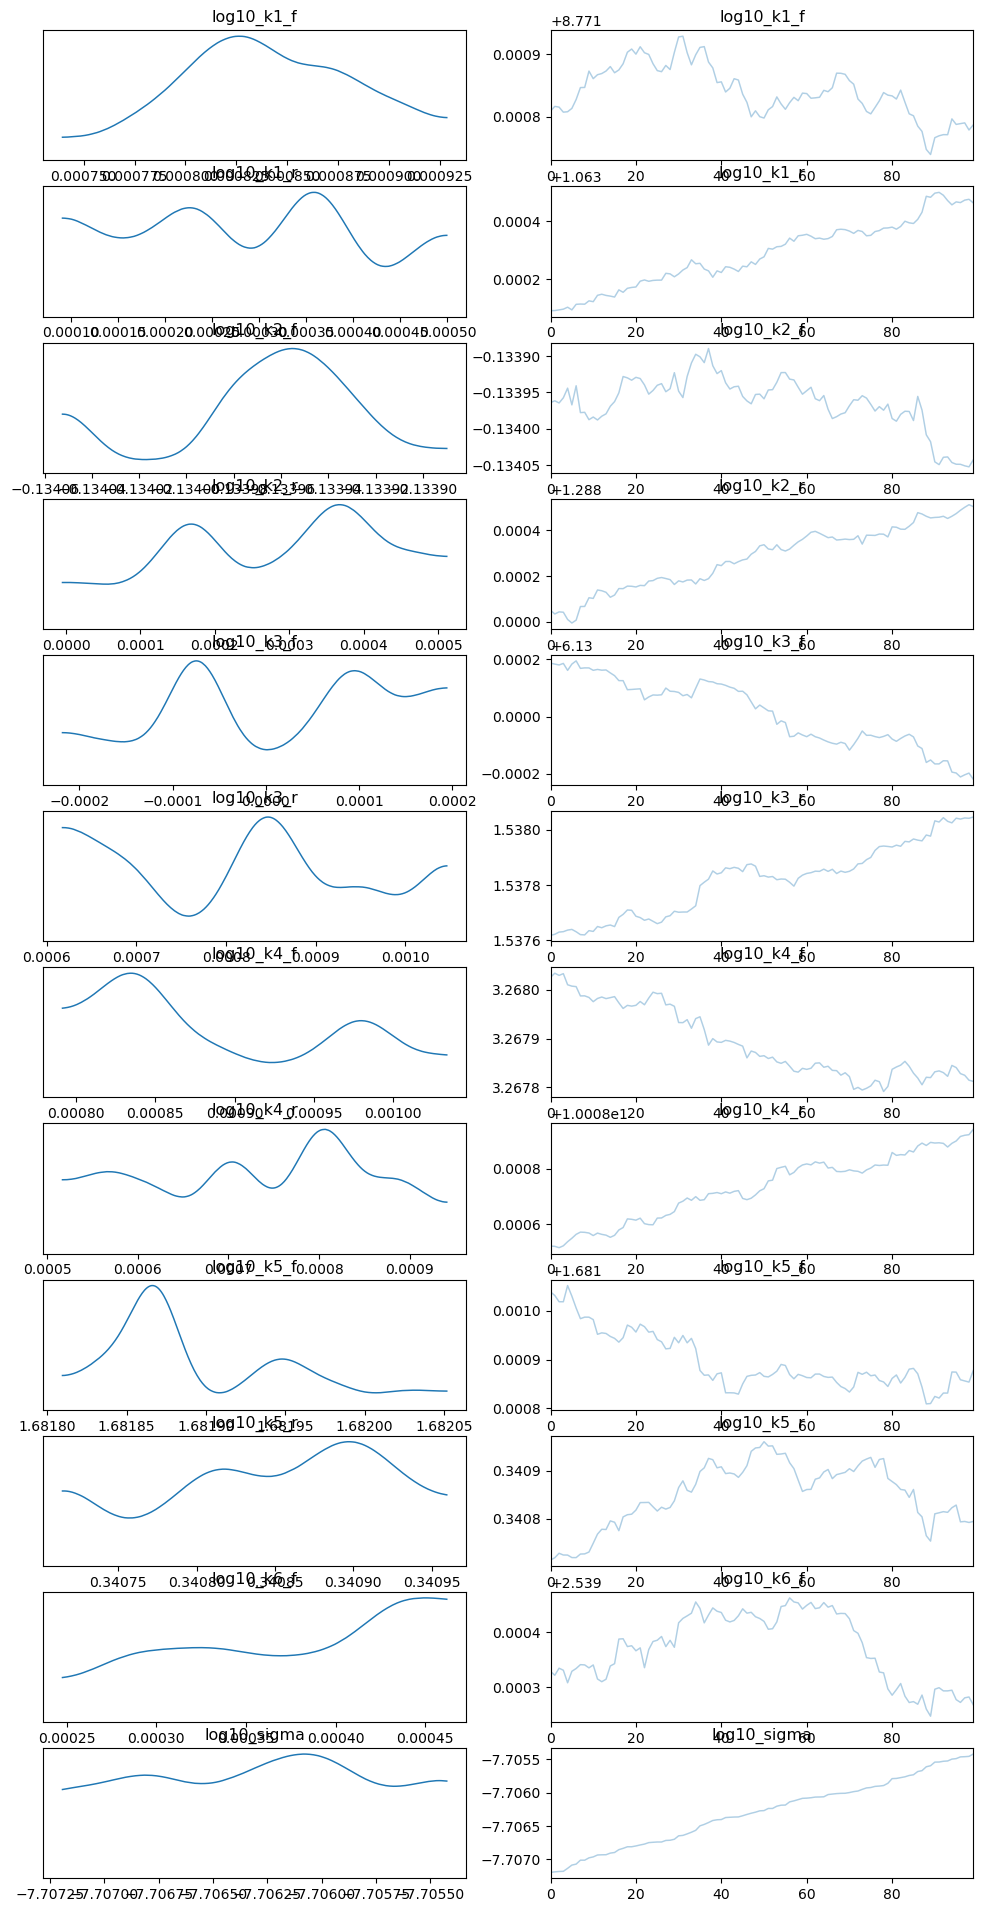

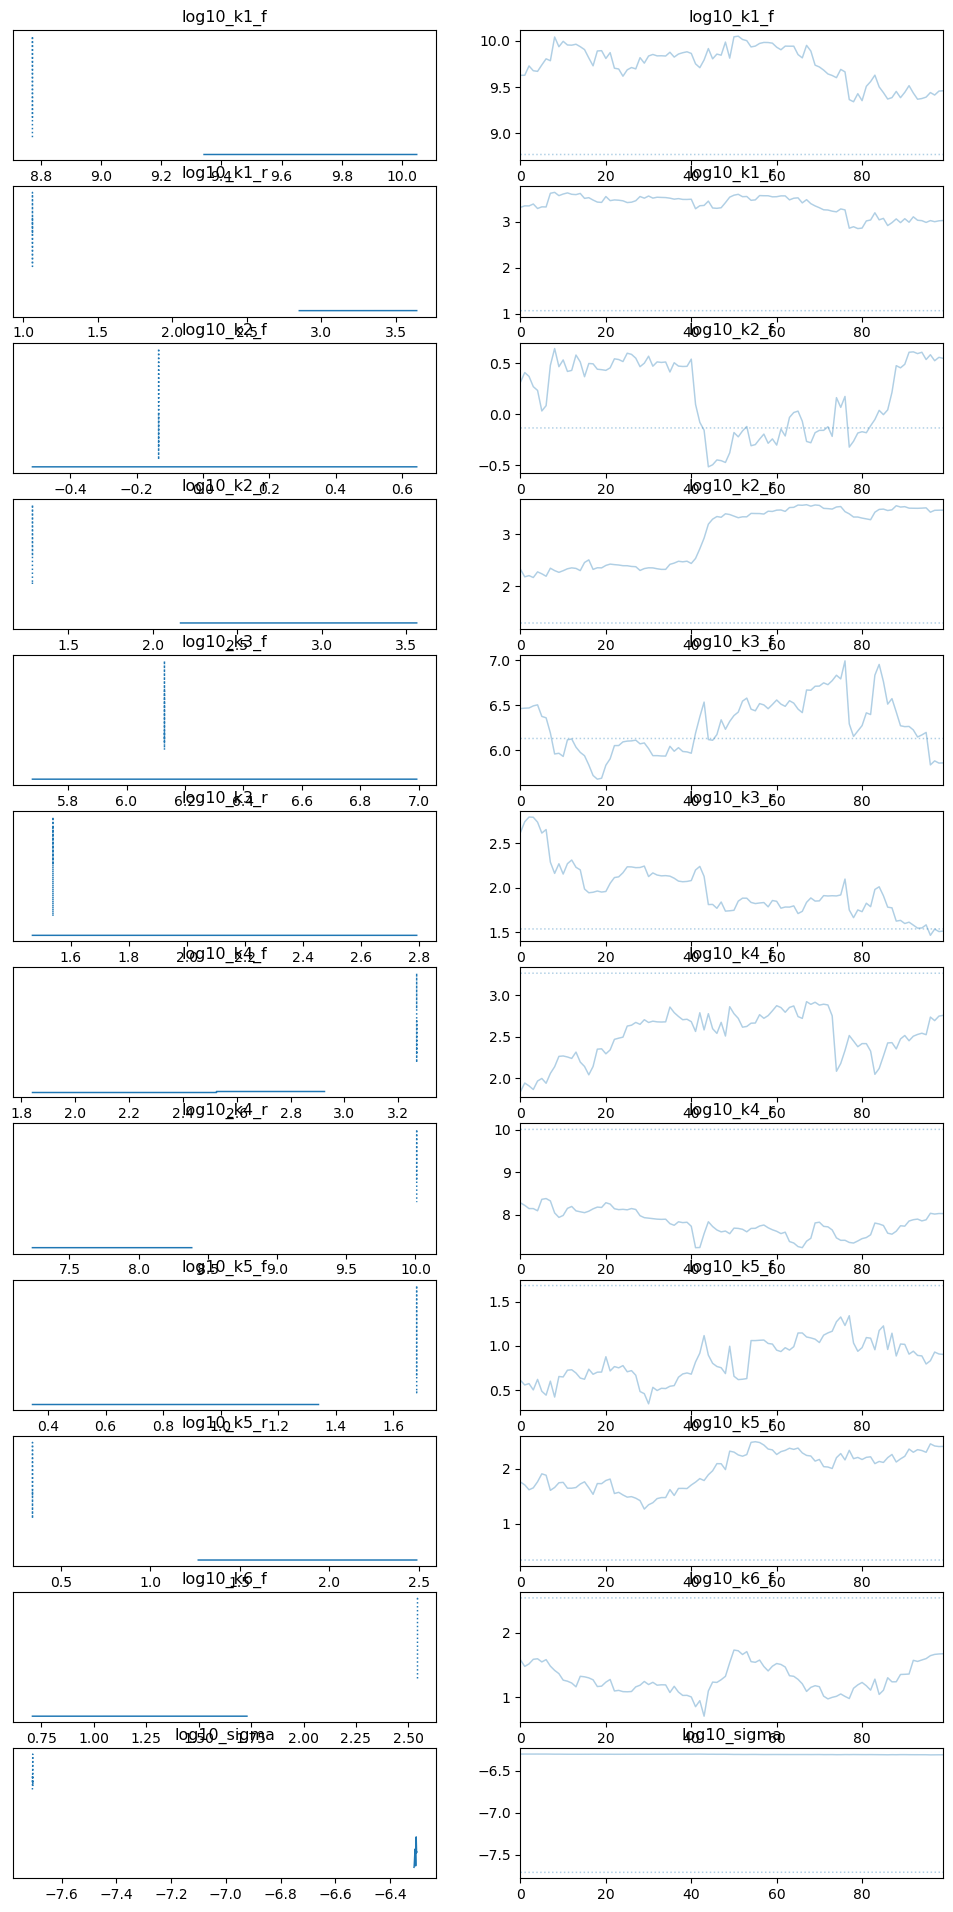

In [28]:
import arviz as az
import matplotlib.pyplot as plt 
import numpy as np

dir = '/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/run_12D_1_1_antiporter_cycle1_experiment1_pyMC_r7_2023-04-14-04-48-33-006511'
data = az.from_json(f'{dir}/inference_data.json')
print(az.summary(data))
print(az.bfmi(data))

posterior_samples = data.posterior.to_array()[:, 0, :]
posterior_array = np.asarray(posterior_samples)
np.savetxt(f'{dir}/chain1_samples.csv',posterior_array.T, delimiter=',')



posterior_samples = data.posterior.to_array()[:, 1, :]
posterior_array = np.asarray(posterior_samples)
np.savetxt(f'{dir}/chain2_samples.csv',posterior_array.T, delimiter=',')


fig = az.plot_trace(data.posterior.sel(chain=[0]))
plt.show()

fig = az.plot_trace(data.posterior.sel(chain=[1]))
plt.show()

fig = az.plot_trace(data.posterior)
plt.show()


# chain1 = data.sel(chain=[0])
# chain2 = data.sel(chain=[1])
# a = np.array(chain1.posterior.values)
# print(a)


In [41]:
import numpy as np

mle_best = [9.82052864,  4.15229136,  2.02628958,  1.12285383,  6.08056484,  3.49170236,
  0.66061842, 10.7932515,   3.92436209,  1.90179934,  4.77232514,  0.94345721,
  0.98699048,  1.12534842,  0.87175144, -7.31648632]

mle_best_k = [ 9.82052864,  4.15229136,  2.02628958,  1.12285383,  6.08056484,  3.49170236,
  0.66061842, 10.7932515,   3.92436209,  1.90179934,  4.77232514]


ref = [10,3,2,2,7,3,3,10,2,2,3, 1,1, 1, 1,-7.3]
ref_k = [10,3,2,2,7,3,3,10,2,2,3]


res = np.sqrt(np.mean(np.square(np.array(mle_best)-np.array(ref)),axis=0))
res_k = np.sqrt(np.mean(np.square(np.array(mle_best_k)-np.array(ref_k)),axis=0))
print(res)
print(res_k)

1.0065068154963432
1.2125516844186708


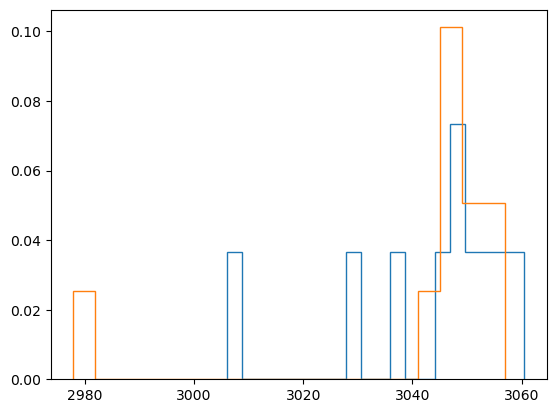

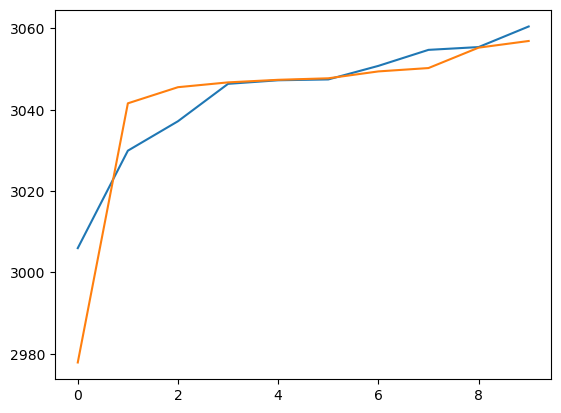

In [55]:
mle_correct = [
3050.798740275155,
3047.4633962051507,
3037.185159341073,
3055.419404856988,
3046.3821918050844,
3060.4859676171986,
3029.9462862141713,
3047.258222555633,
3054.7355545581936,
3005.9811703430587,
]

mle_incorrect = [
3041.589740620753,
3047.7441746425293,
2977.8648130218253,
3055.278392218959,
3045.5571283462687,
3049.436543756354,
3056.917084764781,
3046.7389186940113,
3047.371267703893,
3050.2622611422203
]



plt.hist(mle_correct, bins = 20, density=True, histtype='step')
plt.hist(mle_incorrect, bins = 20, density=True, histtype='step')

plt.figure()
plt.plot(np.sort(mle_correct))
plt.plot(np.sort(mle_incorrect))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


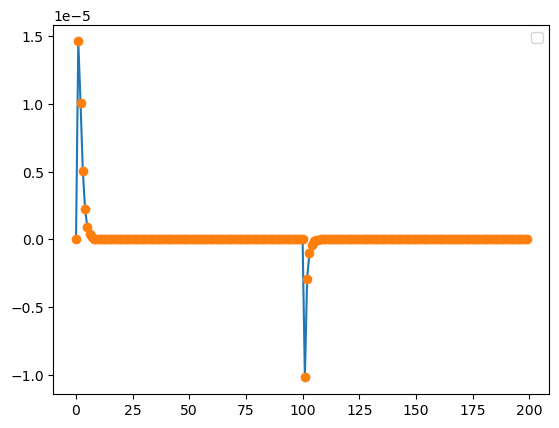

In [71]:
import tellurium as te

rr_model = te.loada("/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/antiporter_1_1_12D_cycle4/antiporter_1_1_12D_cycle4_antimony.txt")

y = []

rr_model.resetToOrigin()
#print(rr_model['conc_OF'])
rr_model.integrator.absolute_tolerance = 1e-15
rr_model.integrator.relative_tolerance = 1e-12
res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
rr_model['conc_H_out'] = 5e-7
rr_model['conc_S_out'] = 1e-3
res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
y.append(res['net_ion_influx'])
rr_model['conc_H_out'] = 1e-7
rr_model['conc_S_out'] = 1e-3
res = rr_model.simulate(0, 1, 100, selections=['time', 'net_ion_influx'])
y.append(res['net_ion_influx'])
y_true = np.hstack(y)
y_peak = np.max(y_true)
noise_sigma = 1e-12
y_obs = y_true + np.random.normal(0,noise_sigma, np.size(y_true))
plt.plot(y_true[:])
plt.plot(y_obs[:], 'o',label=f'')
plt.legend()
rr_model.exportToSBML("antiporter_1_1_12D_cycle4_sbml.xml")

In [72]:
np.exp(3.004264111445670551e+03-2.995191930131089975e+03)

8709.601480750622

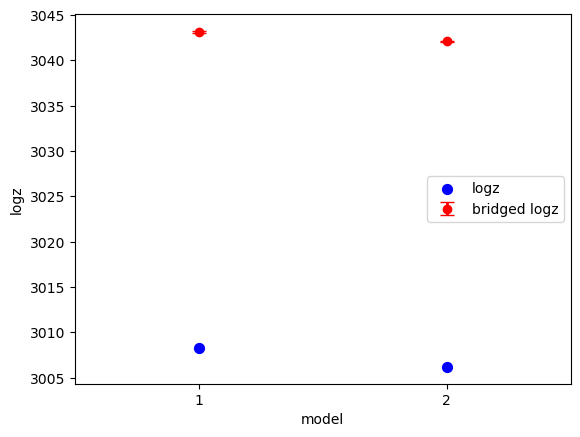

Bayes factor: 2.2728800178745776


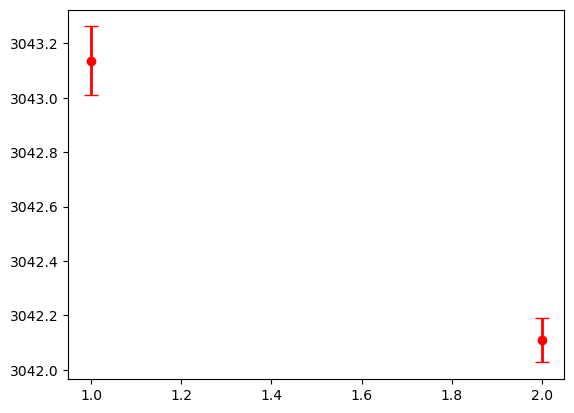

In [85]:


x = [1,2]
logz = [ 3008.28874258395, 3006.198321354671]
bridged_logz = [3043.136008698535, 3042.107807050193]
bridged_logz_err = [0.12623303614592238, 0.08092085451965395]

# plot scatter plot of logz vs x
fig, ax = plt.subplots()
ax.scatter(x, logz, color='b', label='logz', s=50) # set marker size to 50

# plot bridged logz vs x with error bars
ax.errorbar(x, bridged_logz, yerr=bridged_logz_err, fmt='o', color='r', label='bridged logz', capsize=5, elinewidth=2) # set error bar cap size to 5 and linewidth to 2

# add axis labels and legend
ax.set_xlabel('model')
ax.set_ylabel('logz')
ax.legend()
# set x ticks and tick labels
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlim([0.5, 2.5]) 
plt.show()

# plot scatter plot of logz vs x
fig, ax = plt.subplots()
# plot bridged logz vs x with error bars
ax.errorbar(x, bridged_logz, yerr=bridged_logz_err, fmt='o', color='r', label='bridged logz', capsize=5, elinewidth=2) # set error bar cap size to 5 and linewidth to 2


print(f'Bayes factor: {np.exp((bridged_logz[0]-bridged_logz_err[0])-(bridged_logz[1]+bridged_logz_err[1]))}')

In [86]:
import pandas as pd

In [87]:
df = pd.read_csv('/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/run_TEST_1_1_antiporter_cycle4_experiment1_optimization_survey_extended_r42_2023-05-02-12-46-42-662022/optimization/combined_results_all.csv', delimiter=',')

(-3500.0, -2500.0)

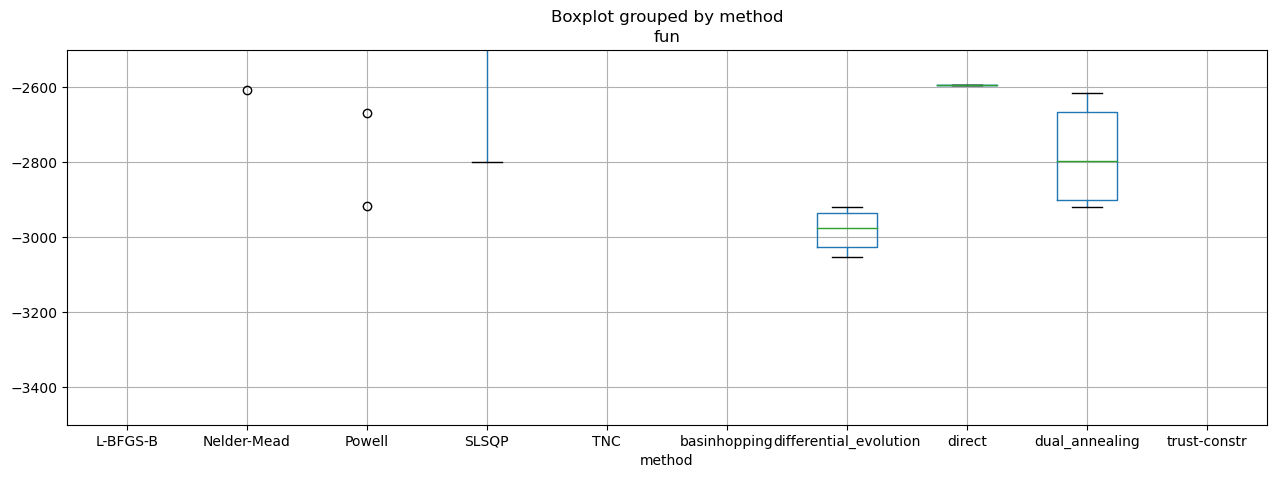

In [117]:
fig, ax = plt.subplots(figsize=(15,5))
ax = df.boxplot(column='fun', by='method', ax=ax)
ax.set_ylim(-3.5e3, -2.5e3)

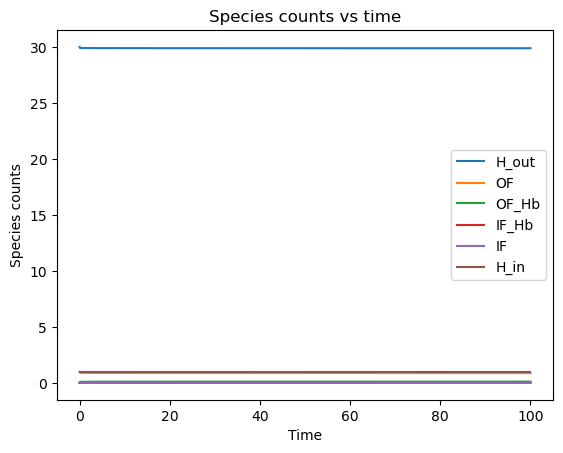

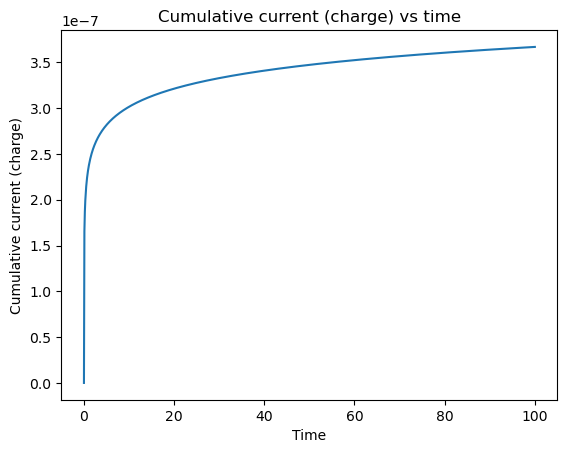

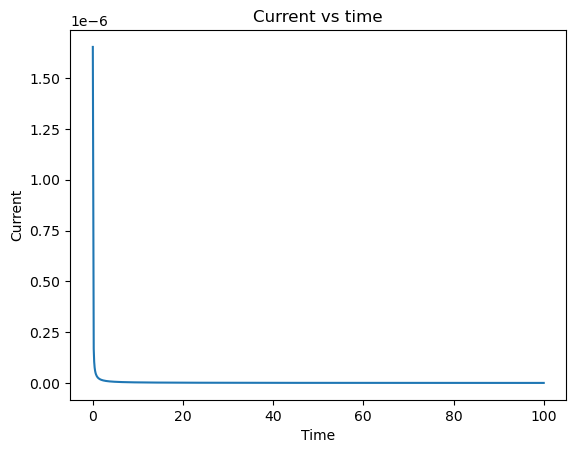

In [121]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Model definition
def model(y, t, C, F, R, T, k_c):
    # Unpack the state variables
    H_out, OF, OF_Hb, IF_Hb, IF, H_in, I_cum = y

    # Calculate V(t)
    V = I_cum / C

    # Update the k_v values
    k_v = np.exp(-V * F / (R * T))

    # Update the k_ij values
    k_ij = k_c * k_v

    # Define the reaction rates
    rate_OF_to_OF_Hb = k_ij[0] * H_out * OF
    rate_OF_Hb_to_OF = k_ij[1] * OF_Hb
    rate_OF_Hb_to_IF_Hb = k_ij[2] * OF_Hb
    rate_IF_Hb_to_OF_Hb = k_ij[3] * IF_Hb
    rate_IF_Hb_to_IF = k_ij[4] * IF_Hb
    rate_IF_to_IF_Hb = k_ij[5] * H_in * IF
    rate_IF_to_OF = k_ij[6] * IF
    rate_OF_to_IF = k_ij[7] * OF

    # Calculate I(t) based on H+ transport rate
    I_t = rate_IF_Hb_to_IF

    # Define the ODEs
    dH_out_dt = -rate_OF_to_OF_Hb + rate_OF_Hb_to_OF
    dOF_dt = rate_OF_Hb_to_OF + rate_IF_to_OF - rate_OF_to_OF_Hb - rate_OF_to_IF
    dOF_Hb_dt = rate_OF_to_OF_Hb - rate_OF_Hb_to_OF - rate_OF_Hb_to_IF_Hb + rate_IF_Hb_to_OF_Hb
    dIF_Hb_dt = rate_OF_Hb_to_IF_Hb - rate_IF_Hb_to_OF_Hb - rate_IF_Hb_to_IF + rate_IF_to_IF_Hb
    dIF_dt = rate_IF_Hb_to_IF - rate_IF_to_IF_Hb + rate_OF_to_IF - rate_IF_to_OF
    dH_in_dt = -rate_IF_to_IF_Hb + rate_IF_Hb_to_IF
    dI_cum_dt = I_t

    return [dH_out_dt, dOF_dt, dOF_Hb_dt, dIF_Hb_dt, dIF_dt, dH_in_dt, dI_cum_dt]

# Initial conditions and parameters
H_out_0, OF_0, OF_Hb_0, IF_Hb_0, IF_0, H_in_0 = 100, 1, 0, 0, 0, 1
y0 = [H_out_0, OF_0, OF_Hb_0, IF_Hb_0, IF_0, H_in_0, 0]
t_values = np.linspace(0, 100, 1000)

C = 1e-6  # Capacitance (F)
F = 96485  # Faraday constant (C/mol)
R = 8.314  # Gas constant (J/(K*mol))
T = 310  # Temperature (K)
k_c = np.array([1, 1, 1, 1, 1, 1, 1, 1])  # k_c_ij values

params = (C, F, R, T, k_c)

# Solve the ODEs
result = odeint(model, y0, t_values, args=params)

# Extract the results
H_out, OF, OF_Hb, IF_Hb, IF, H_in, I_cum = result.T

# Calculate the current (I) at each time point
I_t = np.gradient(I_cum, t_values)

# Plot species counts vs time
plt.figure()
plt.plot(t_values, H_out, label='H_out')
plt.plot(t_values, OF, label='OF')
plt.plot(t_values, OF_Hb, label='OF_Hb')
plt.plot(t_values, IF_Hb, label='IF_Hb')
plt.plot(t_values, IF, label='IF')
plt.plot(t_values, H_in, label='H_in')
plt.xlabel('Time')
plt.ylabel('Species counts')
plt.legend()
plt.title('Species counts vs time')
plt.show()

# Plot cumulative current (charge) vs time
plt.figure()
plt.plot(t_values, I_cum)
plt.xlabel('Time')
plt.ylabel('Cumulative current (charge)')
plt.title('Cumulative current (charge) vs time')
plt.show()

# Plot current vs time
plt.figure()
plt.plot(t_values, I_t)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current vs time')
plt.show()
